# Securing ML Models

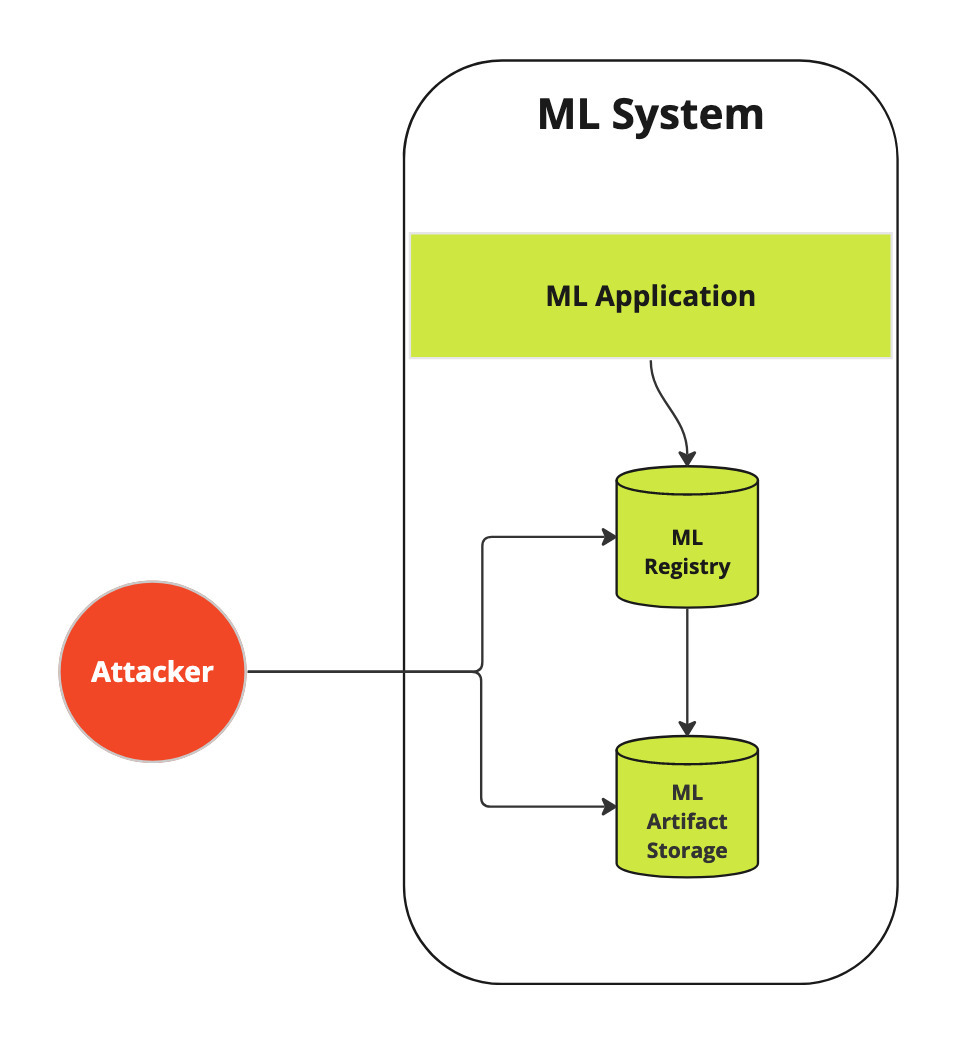

In [1]:
from IPython.display import Image
Image(filename="./imgs/code_injection_attack_on_serialized_model_frame1.jpg", width=600)

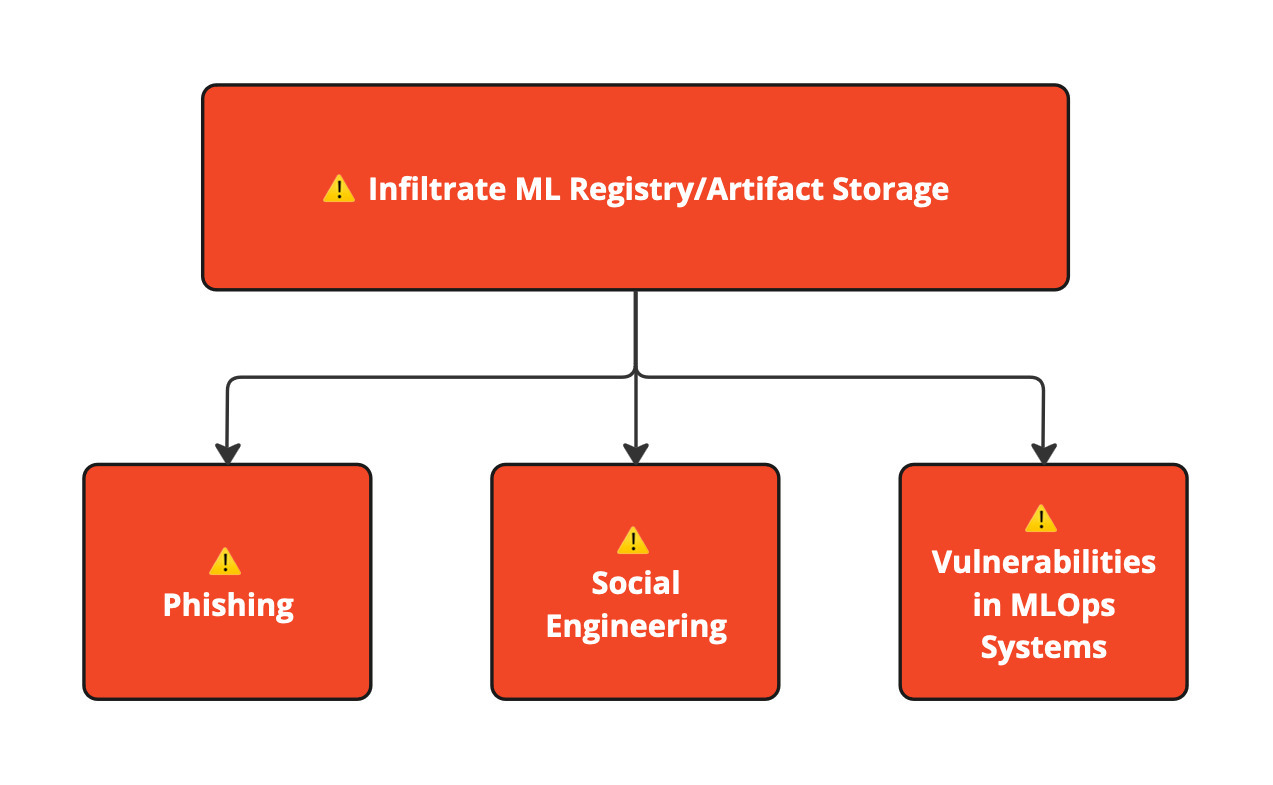

In [2]:
Image(filename="imgs/code_injection_attack_on_serialized_model_frame3.jpg", width=600)

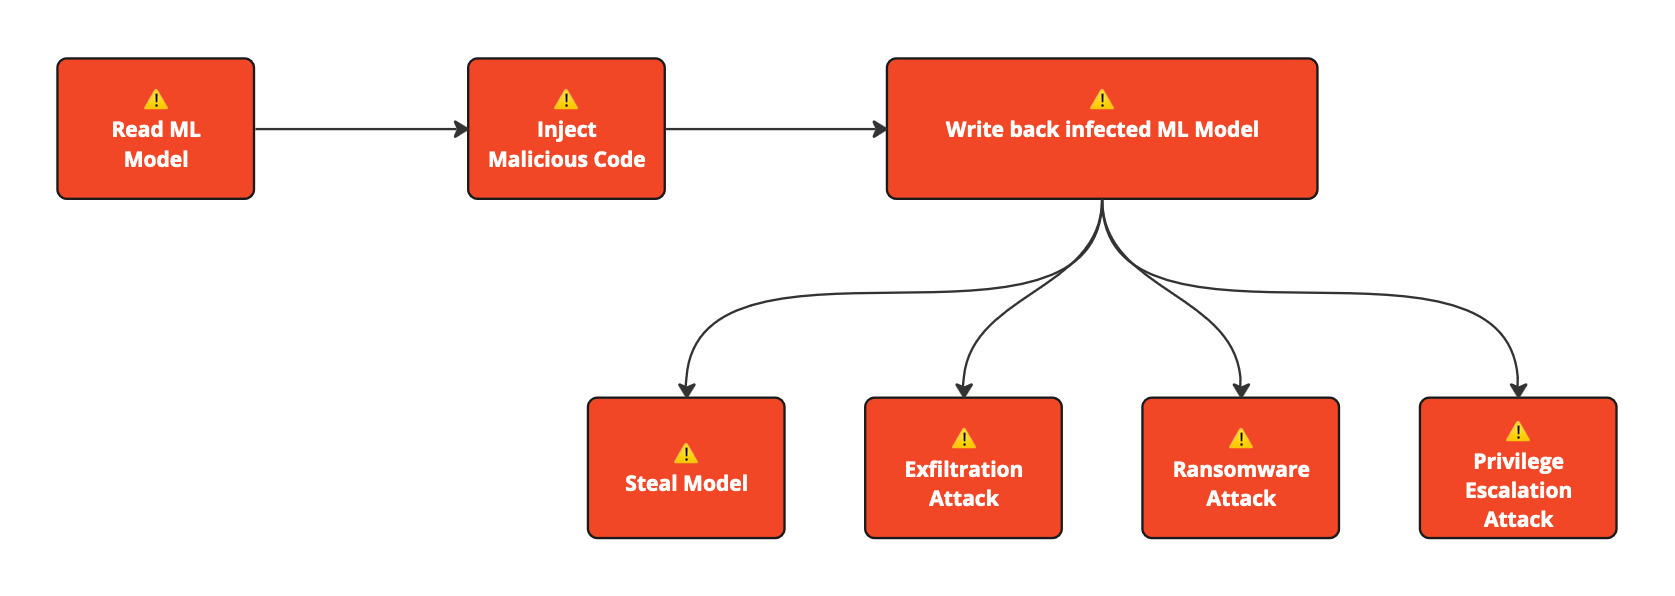

In [3]:
Image(filename="imgs/code_injection_attack_on_serialized_model_frame2.jpg", width=600)

In [4]:
import torch
import os 
from utils.pytorch_sentiment_model import download_model, predict_sentiment
from utils.pickle_codeinjection import PickleInject, get_payload
%env TOKENIZERS_PARALLELISM=false


/Users/mehrinkiani/mambaforge/envs/modelscan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


env: TOKENIZERS_PARALLELISM=false


# Saving Model


We first look at how a normal workflow works where an ML model is loaded via a pickle file.

In [5]:
# Save a model for sentiment analysis
model_directory = "PyTorchModels"
if not os.path.isdir(model_directory):
    os.mkdir(model_directory)

safe_model_path = os.path.join(model_directory, "safe_model.pt")

sentiment_model = download_model(safe_model_path)

# Scanning for Injection Attack

In [6]:
!modelscan --path PyTorchModels/safe_model.pt

Scanning /Users/mehrinkiani/Documents/modelscan/examples/PyTorchModels/safe_model.pt:safe_model/data.pkl using pickle model scan

--- Summary ---

 No issues found! 🎉


# Model Prediction

In [7]:
sentiment = predict_sentiment("Stock market was bearish today", torch.load(safe_model_path))

The overall sentiment is: negative with a score of: 85.9%


# Code Injection Attack

In [8]:
command = "system"
malicious_code = """cat ~/.aws/secrets
    """

unsafe_model_path = os.path.join(model_directory, "unsafe_model.pt")


payload = get_payload(command, malicious_code)
torch.save(
    torch.load(safe_model_path),
    f=unsafe_model_path,
    pickle_module=PickleInject([payload]),
)

# Model Prediction 


In [9]:
sentiment = predict_sentiment("Stock market was bearish today", torch.load(unsafe_model_path))

aws_access_key_id=<access_key_id>
aws_secret_access_key=<aws_secret_key>
The overall sentiment is: negative with a score of: 85.9%


# Scanning Unsafe GPT-2 Model

In [10]:
!modelscan --path  ./PyTorchModels/unsafe_model.pt

Scanning /Users/mehrinkiani/Documents/modelscan/examples/PyTorchModels/unsafe_model.pt:unsafe_model/data.pkl using pickle model scan

--- Summary ---

Total Issues: 1

Total Issues By Severity:

    - LOW: 0
    - MEDIUM: 0
    - HIGH: 0
    - CRITICAL: 1

--- Issues by Severity ---

--- CRITICAL ---

Unsafe operator found:
  - Severity: CRITICAL
  - Description: Use of unsafe operator 'system' from module 'posix'
  - Source: /Users/mehrinkiani/Documents/modelscan/examples/PyTorchModels/unsafe_model.pt:unsafe_model/data.pkl
